## Materialization Correctness
To ensure the materialization code is working correctly, in this notebook, we create a medium size graph with several ml models and manually check the potential, recreation cost, and |pipelines| to compare with the computed values from the materialization code.

In [1]:
# numpy and pandas for data manipulation
import sys
import os
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import cPickle as pickle

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/'
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/collaborative-optimizer'
root_data = ROOT + '/data'

sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.executor import CollaborativeExecutor
from experiment_graph.workload import Workload
from experiment_graph.execution_environment import ExecutionEnvironment
from experiment_graph.benchmark_helper import BenchmarkMetrics
from experiment_graph.data_storage import DedupedStorageManager
from experiment_graph.storage_managers import storage_profiler

DATABASE_PATH = root_data + '/experiment_graphs/home-credit-default-risk/materialization-test'
N_ESTIMATOR = 100

In [2]:
class MaterializationTest(Workload):
    def run(self, execution_environment, root_data):
        # Load Data
        train = execution_environment.load(root_data +
                                           '/openml/task_id=31/train.csv')
        test = execution_environment.load(root_data +
                                          '/openml/task_id=31/test.csv')

        test_labels = test['class']
        test = test.drop('class')

        train_labels = train['class']
        train = train.drop(columns=['class'])

        train2 = train.drop('checking_status')
        test2 = test.drop('checking_status')
        from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
        scaler2 = MinMaxScaler(feature_range=(0, 1))
        scaler2.fit(train2)
        train2 = scaler2.transform(train2)
        test2 = scaler2.transform(test2)

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)
        # Random Forest 1 (n_estimator = 10)
        from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
        random_forest10 = RandomForestClassifier(
            n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
        random_forest10.fit(train, train_labels)

        # Execute
        random_forest10.trained_node.data()

        print 'random_forest10: {}'.format(
            random_forest10.score(test, test_labels).data())

        # Random Forest 2 (n_estimator = 100)
        from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
        random_forest100 = RandomForestClassifier(
            n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
        random_forest100.fit(train, train_labels)

        # Execute
        random_forest100.trained_node.data()

        print 'random_forest100: {}'.format(
            random_forest100.score(test, test_labels).data())

        # Logistic Regression
        from experiment_graph.sklearn_helper.linear_model import LogisticRegression

        # Make the model with the specified regularization parameter
        log_reg = LogisticRegression(C=0.0001)

        # Train on the training data
        log_reg.fit(train, train_labels)

        print 'log_reg: {}'.format(log_reg.score(test, test_labels).data())

        # Gradient Boosted 1 (n_estimator = 60)
        from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

        model60 = LGBMClassifier(
            n_estimators=60,
            objective='binary',
            class_weight='balanced',
            learning_rate=0.05,
            reg_alpha=0.1,
            reg_lambda=0.1,
            subsample=0.8,
            n_jobs=-1,
            random_state=50)

        # Train the model
        model60.fit(
            train,
            train_labels,
            custom_args={
                'eval_metric': 'accuracy',
                'verbose': 200
            })

        # Make predictions
        print 'model60: '.format(model60.score(test, test_labels).data())

        # Gradient Boosted 2 (n_estimator = 100)
        from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

        model100 = LGBMClassifier(
            n_estimators=100,
            objective='binary',
            class_weight='balanced',
            learning_rate=0.05,
            reg_alpha=0.1,
            reg_lambda=0.1,
            subsample=0.8,
            n_jobs=-1,
            random_state=50)

        # Train the model
        model100.fit(
            train,
            train_labels,
            custom_args={
                'eval_metric': 'accuracy',
                'verbose': 200
            })

        # Make predictions
        print 'model100: {}'.format(model100.score(test, test_labels).data())

        # Gradient Boosted 3 (n_estimator = 60) modified train
        from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

        model60_2 = LGBMClassifier(
            n_estimators=60,
            objective='binary',
            class_weight='balanced',
            learning_rate=0.05,
            reg_alpha=0.1,
            reg_lambda=0.1,
            subsample=0.8,
            n_jobs=-1,
            random_state=50)

        # Train the model
        model60_2.fit(
            train2,
            train_labels,
            custom_args={
                'eval_metric': 'accuracy',
                'verbose': 200
            })

        # Make predictions
        print 'model60_2: {}'.format(
            model60_2.score(test2, test_labels).data())
        return True

In [3]:
# Prepare the Data
# Create Execution Environment with AllMaterializer
local_profile = storage_profiler.get_profile(root_data+'/profiles/local-dedup')
ee = ExecutionEnvironment(DedupedStorageManager()) 
workload = MaterializationTest()
executor = CollaborativeExecutor(ee, cost_profile=local_profile)
executor.end_to_end_run(workload=workload, root_data=root_data)

{"Agg": 0.09642666666666667, "SK_Model": 5.86940990518854e-05, "Evaluation": 0.04334545454545455, "Feature": 0.03777813765182186, "Dataset": 0.0006677262236078122}
creating a new root node
creating a new root node


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


random_forest10: {'accuracy': 0.79000000000000004}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


random_forest100: {'accuracy': 0.76000000000000001}
log_reg: {'accuracy': 0.69999999999999996}
model60: 
model100: {'accuracy': 0.81000000000000005}
model60_2: {'accuracy': 0.78000000000000003}


True

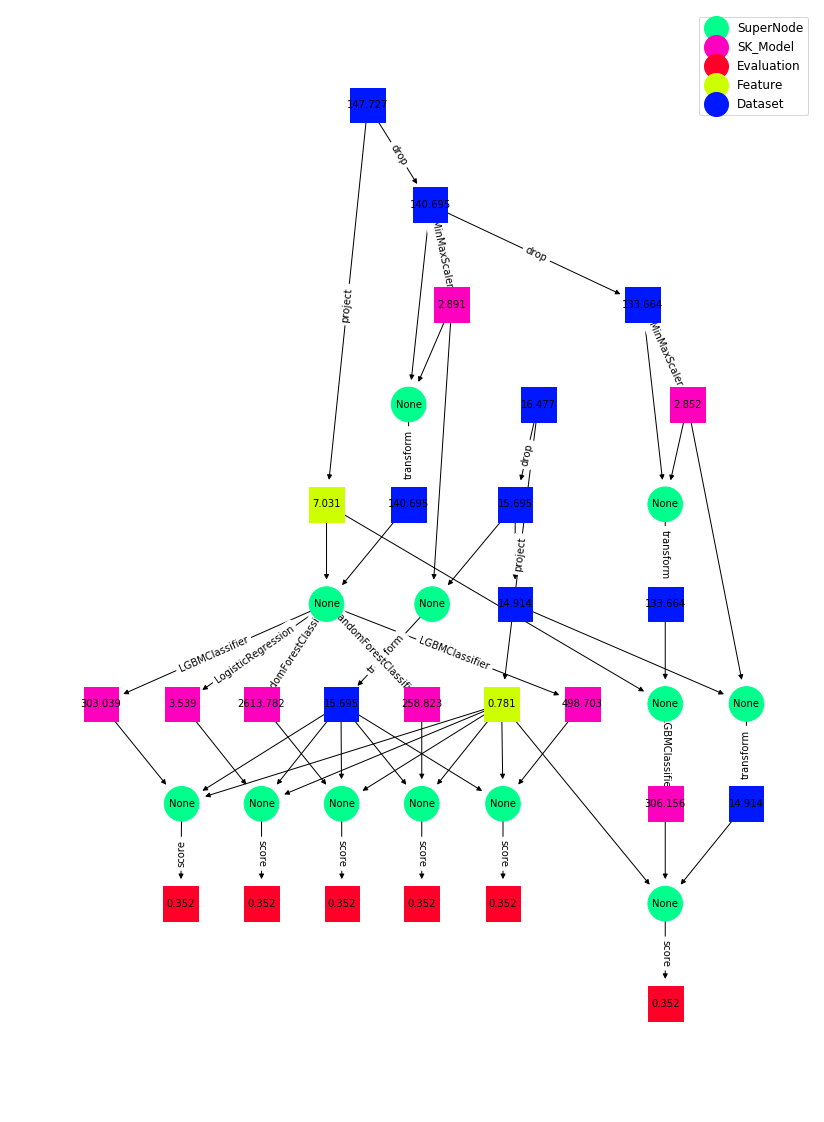

In [4]:
executor.execution_environment.experiment_graph.plot_graph(
    plt,
    figsize=(14, 20),
    labels_for_vertex=['size'],
    labels_for_edges=['name'],
    vertex_size=1200)

## Simple Based Materialization

In [5]:
from experiment_graph.materialization_algorithms.materialization_methods import HeuristicsMaterializer
budget = 1024
heuristicsMat = HeuristicsMaterializer(storage_budget=budget, modify_graph=True)

In [6]:
# Prepare the Data
# Create Execution Environment with AllMaterializer
ee = ExecutionEnvironment(DedupedStorageManager())
workload = MaterializationTest()
executor = CollaborativeExecutor(ee, materializer=heuristicsMat)
executor.end_to_end_run(workload=workload, root_data=root_data)

creating a new root node
creating a new root node


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


random_forest10: {'accuracy': 0.79000000000000004}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


random_forest100: {'accuracy': 0.76000000000000001}
log_reg: {'accuracy': 0.69999999999999996}
model60: 
model100: {'accuracy': 0.81000000000000005}
model60_2: {'accuracy': 0.78000000000000003}


True

In [7]:
graph = executor.execution_environment.experiment_graph.graph
for n,d in graph.nodes(data=True):
    if d['type'] != 'SuperNode':
        print d['mat'], d['rho'], d['type'], d['size']
        

True 0.177358113444 Evaluation 0.3515625
True 0.00194857150937 Feature 7.03125
True 0.0868191463963 Evaluation 0.3515625
True 0.000885010026581 Dataset 15.6953125
True 0.000964719202645 Dataset 14.9140625
True 0.00473034762532 SK_Model 2.8515625
False 9.95096180052e-05 Dataset 133.6640625
True 0.00481975243135 SK_Model 2.890625
True 0.0403439815232 Evaluation 0.3515625
True 0.0174824833291 Feature 0.78125
True inf Dataset 147.7265625
False 9.79336895691e-05 Dataset 140.6953125
True 0.000900252384042 Dataset 14.9140625
True 0.00015163297837 SK_Model 258.823242188
True 0.073669361353 Evaluation 0.3515625
False 5.63823685431e-05 SK_Model 498.703125
True 0.00010678857301 Dataset 133.6640625
False 3.07446324875e-05 SK_Model 2613.78222656
True 0.00367315613606 SK_Model 3.5390625
True 0.304385344159 Evaluation 0.3515625
False 7.74542687576e-05 SK_Model 303.0390625
True 0.000102310893306 Dataset 140.6953125
True 0.000112299404884 SK_Model 306.15625
True 0.000931384930157 Dataset 15.6953125
Tru

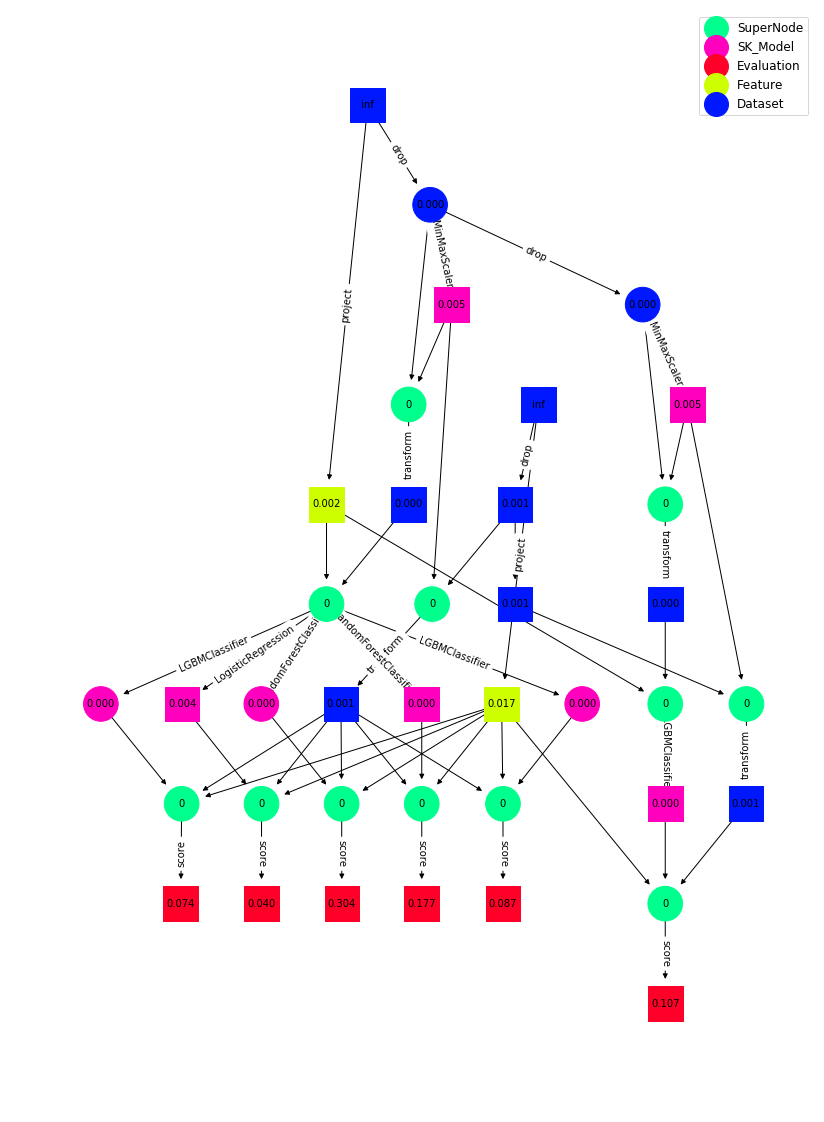

In [8]:
executor.execution_environment.experiment_graph.plot_graph(
    plt,
    figsize=(14, 20),
    labels_for_vertex=['rho'],
    labels_for_edges=['name'],
    vertex_size=1200)

In [9]:
print 'Total size of all the artifacts: {}'.format(
    executor.execution_environment.experiment_graph.get_total_size())

print 'Real size of the materialized artifacts: {}'.format(
    executor.execution_environment.experiment_graph.get_real_size())

print 'Sum of size of all the materialized artifacts: {}'.format(
    executor.execution_environment.experiment_graph.
    get_total_materialized_size())

Total size of all the artifacts: 4773.84765625
Real size of the materialized artifacts: 1022.10449219
Sum of size of all the materialized artifacts: 1083.96386719


## Storage Aware Materialization

In [10]:
from experiment_graph.materialization_algorithms.materialization_methods import StorageAwareMaterializer
budget = 1024
storage_aware = StorageAwareMaterializer(storage_budget=budget, modify_graph=True)

In [11]:
# Prepare the Data
# Create Execution Environment with AllMaterializer
local_profile = storage_profiler.get_profile(root_data+'/profiles/local-dedup')
ee = ExecutionEnvironment(DedupedStorageManager())
workload = MaterializationTest()
executor = CollaborativeExecutor(ee, cost_profile=local_profile, materializer=storage_aware)
executor.end_to_end_run(workload=workload, root_data=root_data)

{"Agg": 0.09642666666666667, "SK_Model": 5.86940990518854e-05, "Evaluation": 0.04334545454545455, "Feature": 0.03777813765182186, "Dataset": 0.0006677262236078122}
creating a new root node
creating a new root node


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


random_forest10: {'accuracy': 0.79000000000000004}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


random_forest100: {'accuracy': 0.76000000000000001}
log_reg: {'accuracy': 0.69999999999999996}
model60: 
model100: {'accuracy': 0.81000000000000005}
model60_2: {'accuracy': 0.78000000000000003}
skipping node since the load cost is greater than the recreation cost: DBDC4A474E8B084B17D4A95D82CBA082
current size: 1045.13574219
current size: 1348.17480469
current size: 1348.17480469


True

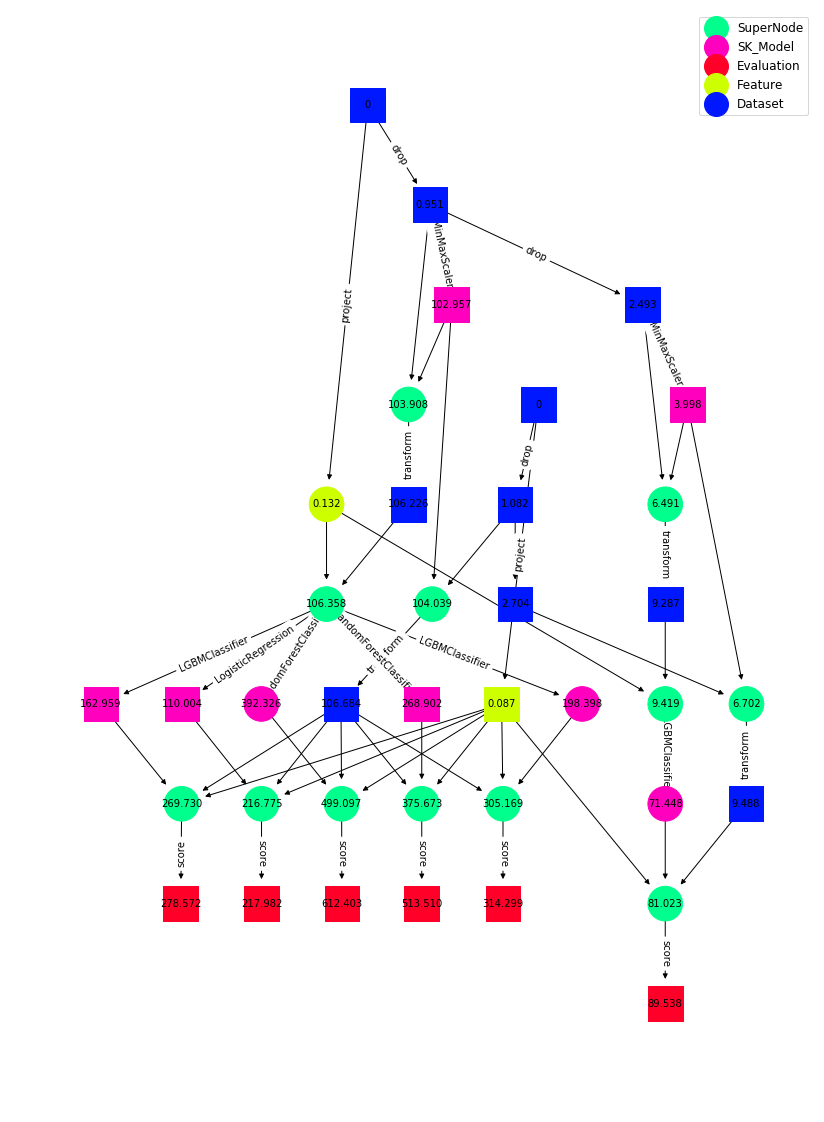

In [12]:
executor.execution_environment.experiment_graph.plot_graph(
    plt,
    figsize=(14, 20),
    labels_for_vertex=['recreation_cost'],
    labels_for_edges=['name'],
    vertex_size=1200)

In [13]:
print 'Total size of all the artifacts: {}'.format(
    executor.execution_environment.experiment_graph.get_total_size())

print 'Real size of the materialized artifacts: {}'.format(
    executor.execution_environment.experiment_graph.get_real_size())

print 'Sum of size of all the materialized artifacts: {}'.format(
    executor.execution_environment.experiment_graph.
    get_total_materialized_size())

Total size of all the artifacts: 4773.84765625
Real size of the materialized artifacts: 1012.02636719
Sum of size of all the materialized artifacts: 1348.17480469


In [14]:
graph = executor.execution_environment.experiment_graph.graph
for n, d in graph.nodes(data=True):
    if d['mat']:
        print n, d['compute_cost'],d['load_cost']

AD4CB332A23AF19C1150A43876F369FD 137.837 0.0152386363636
9702F0558BBE991A5F797648D924E60F 9.13 0.0152386363636
C42F2CDE6885202579E291D6BC09DAA6 1.082 0.010480171744
F9AF74A654F14A9A8F31F5DAED9C02F0 2.786 0.00995851063178
1D4D55E9CF2EB86188615EFCAD918B8C 1.505 0.000167369891828
B6D925223AFD41F381EEEE2967E26DA5 1.542 0.0892509996852
30BA78B1E3083C85ED55C85637140914 102.006 0.000169662630072
15CACA3BC2BC659A8F81EFE984D2D68A 1.207 0.0152386363636
1F22A9E7687B4B9E5ED728910FC93F1A 0.087 0.0295141700405
train.csv{} 0 0.0986408997047
991F3690053BFE13CEDF335CFB510266 0.951 0.0939459496949
0FC9E6AC48D4FCE5147BEB34DDDDFD50 1.622 0.00995851063178
2CCB1EC7A9FF11E906F0C2558E6A6CFF 162.544 0.0151913970139
791406BCA0FD8631232A21A8C5810F80 8.842 0.0152386363636
596B0B62E30B223C703490CF5D545DAF 2.796 0.0892509996852
08EC727794D7B5A6622E108F368DAD1D 3.646 0.000207722084926
448D4A612F200A65509F41E5FE4B3F77 113.306 0.0152386363636
D5F35493D6BEBF4BCE5EE70EACDF6617 56.601 0.017786604751
C2B2A08B3D0EFA08C2A06

In [15]:
for graph.nodes

SyntaxError: invalid syntax (<ipython-input-15-fca7cf8fe607>, line 1)